In [1]:
import os 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import torch 
import torch.nn as nn 
import torch.optim as optim
import timm 
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset 
from torch.utils.data import Subset
from torchvision import datasets, transforms 
from torchvision.transforms import ToTensor, Resize, Compose, Normalize 
from torchvision.utils import make_grid 
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler 
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix 


# Load the dataset 

/home/shinds/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


### 클래스 별 이미지 수 확인
1. 클래스 별 이미지를 그대로 사용
2. 클래스 별 이미지 중에서도 알, 번데기, 유충, 성충으로 분리하여 학습에 사용 

In [2]:
# farm_insects 내의 각 클래스 별 이미지 수 확인
pest_path = "/home/shinds/my_document/pest/farm_insects"
pest_classes = os.listdir(pest_path)
pest_classes
print(len(pest_classes), pest_classes)
# 각 클래스 별 이미지 수 확인
for pest_class in pest_classes:
    pest_class_path = os.path.join(pest_path, pest_class)
    pest_class_images = os.listdir(pest_class_path)
    print(f"{pest_class}: {len(pest_class_images)}")    


15 ['Western Corn Rootworms', 'Citrus Canker', 'Fruit Flies', 'Africanized Honey Bees (Killer Bees)', 'Aphids', 'Colorado Potato Beetles', 'Thrips', 'Corn Earworms', 'Fall Armyworms', 'Corn Borers', 'Cabbage Loopers', 'Brown Marmorated Stink Bugs', 'Spider Mites', 'Tomato Hornworms', 'Armyworms']
Western Corn Rootworms: 100
Citrus Canker: 104
Fruit Flies: 101
Africanized Honey Bees (Killer Bees): 97
Aphids: 88
Colorado Potato Beetles: 112
Thrips: 109
Corn Earworms: 110
Fall Armyworms: 113
Corn Borers: 115
Cabbage Loopers: 104
Brown Marmorated Stink Bugs: 114
Spider Mites: 119
Tomato Hornworms: 109
Armyworms: 96


In [3]:
# 1. 데이터 전처리 정의
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# 2. 데이터셋 및 DataLoader
data_dir = "/home/shinds/my_document/pest/farm_insects"

# 임시로 전체 데이터셋(라벨 추출용, transform은 val_transform으로)
temp_dataset = datasets.ImageFolder(root=data_dir, transform=val_transform)
indices = list(range(len(temp_dataset)))
from sklearn.model_selection import train_test_split
train_indices, val_indices = train_test_split(indices, test_size=0.2, stratify=temp_dataset.targets, random_state=42)



# train/val 각각 transform 다르게 적용
train_dataset = Subset(datasets.ImageFolder(root=data_dir, transform=train_transform), train_indices)
val_dataset = Subset(datasets.ImageFolder(root=data_dir, transform=val_transform), val_indices)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 원하는 모델 이름으로 변경 가능 (예: 'efficientnet_b0', 'resnet50', 'vit_base_patch16_224', 등)
model_name = "resnet50"
model = timm.create_model(model_name, pretrained=True, num_classes=15)
model = model.to(device)

In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)

In [6]:
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None or val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

In [7]:
num_epochs = 100
patience = 5  # 개선 없을 때 몇 번 기다릴지
min_delta = 0.001  # 개선으로 인정할 최소 loss 감소량
best_val_loss = float('inf')
best_acc = 0.0
save_path = "best_model.pth"
train_losses = []
val_losses = []
val_accuracies = []

save_dir = f"results_{model_name}"
os.makedirs(save_dir, exist_ok=True)

# 모델 저장 경로 지정
save_path = os.path.join(save_dir, "best_model.pth")
last_model_path = os.path.join(save_dir, "last_model.pth")
early_stopping = EarlyStopping(patience=patience, min_delta=min_delta)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # 검증 loss 계산
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_loss /= len(val_loader)
    val_acc = 100 * correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    # --- best model 저장 ---
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_acc = val_acc
        torch.save(model.state_dict(), save_path)

    early_stopping(val_loss)
    if early_stopping.early_stop:
        print(f"조기 종료! {epoch+1} epoch에서 validation loss 개선 없음.")
        break

# 마지막 모델도 저장
torch.save(model.state_dict(), last_model_path)
print(f"Best model saved at {save_path} (Val Loss: {best_val_loss:.4f}, Val Acc: {best_acc:.4f})")
print(f"Last model saved at {last_model_path}")

/home/shinds/.local/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1, Train Loss: 2.7133, Val Loss: 2.7104, Val Acc: 7.28%
Epoch 2, Train Loss: 2.7086, Val Loss: 2.7029, Val Acc: 10.13%
Epoch 3, Train Loss: 2.6975, Val Loss: 2.6974, Val Acc: 11.39%
Epoch 4, Train Loss: 2.6944, Val Loss: 2.6931, Val Acc: 12.03%
Epoch 5, Train Loss: 2.6884, Val Loss: 2.6876, Val Acc: 14.87%
Epoch 6, Train Loss: 2.6809, Val Loss: 2.6816, Val Acc: 15.51%
Epoch 7, Train Loss: 2.6718, Val Loss: 2.6767, Val Acc: 17.09%
Epoch 8, Train Loss: 2.6634, Val Loss: 2.6701, Val Acc: 20.25%
Epoch 9, Train Loss: 2.6581, Val Loss: 2.6661, Val Acc: 20.89%
Epoch 10, Train Loss: 2.6497, Val Loss: 2.6568, Val Acc: 22.78%
Epoch 11, Train Loss: 2.6407, Val Loss: 2.6506, Val Acc: 26.58%
Epoch 12, Train Loss: 2.6315, Val Loss: 2.6414, Val Acc: 28.80%
Epoch 13, Train Loss: 2.6216, Val Loss: 2.6345, Val Acc: 30.38%
Epoch 14, Train Loss: 2.6134, Val Loss: 2.6267, Val Acc: 32.59%
Epoch 15, Train Loss: 2.6041, Val Loss: 2.6172, Val Acc: 33.23%
Epoch 16, Train Loss: 2.5921, Val Loss: 2.6046, Va

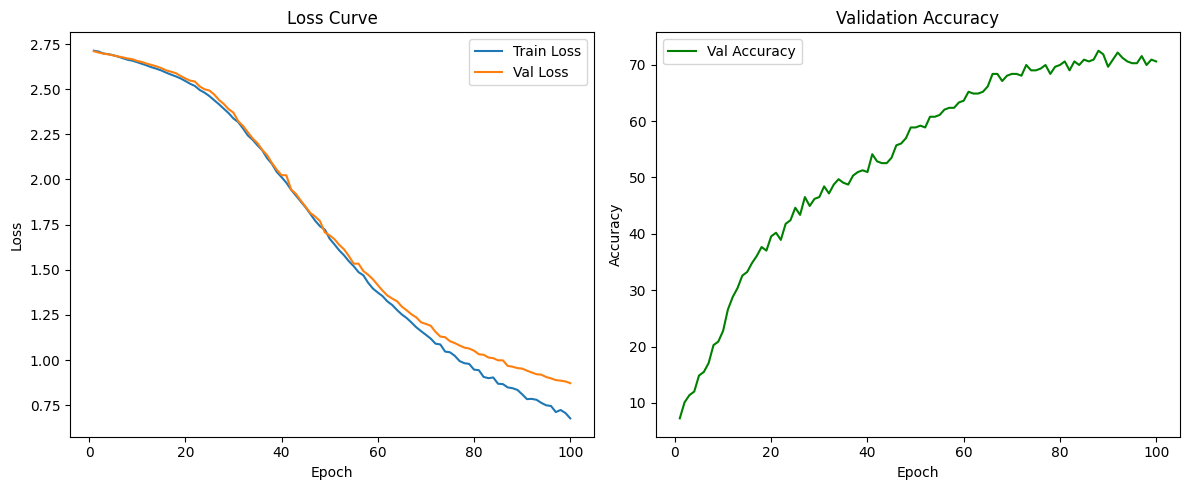

In [8]:
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, val_accuracies, label='Val Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig(os.path.join(save_dir, "loss_accuracy_curve.png"))  
plt.show()